In [1]:
import numpy as np
import sys
sys.path+=['../']
from IntegrableResonanceModel import IntegrableResonanceModel
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

/Users/shadden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Determination of Dynamical Frequencies
This notebook provides code for computing the dynamical frequencies 
dynamical frequencies $\Omega_\text{res} \equiv \frac{\partial H_0}{\partial {\cal J}}$
and $\Omega_\text{sec} \equiv \frac{\partial H_0}{\partial {\cal J}^*}$
where $({\cal J},{\cal J}^*)$ actions defined by the transformation:

$$
{\cal J} = \frac{1}{2\pi}\oint Jd\theta~~;~~\zeta =\frac{2\pi}{T_\text{res}}t \\
{\cal J}^* =J^* ~~;~~\zeta^*=\theta^*+\rho({\zeta};{\cal J}^*,{\cal J})
$$

The algorithm is based on <a href=https://ui.adsabs.harvard.edu/abs/1990CeMDA..49...43H/abstract>Henrard (1990)</a>.

In [2]:
#           ****** Note *******
# Computing accurate secular frequencies can
# sometimes require increasing the number of 
# quadrature points, 'n_quad_pts'
res_model=IntegrableResonanceModel(3,1,n_quad_pts=61)

In [3]:
# Convenience function that will be used for event-monitoring
# by scipy.integrate.solve_ivp
def event(t,y,J0):
    """
    Determine when J returns to initial
    value, J0
    """
    J = y[2]
    return J - J0
def calc_frequencies(delta_theta,Jstar,res_model,full_output = False):
    """
    Determine the dynamical frequencies associated with 
    initial libration amplitude delta_thetaand conserved 
    quantity Jstar.
    
    Based on Henrard (1990, doi: 10.1007/BF00048581).
    
    The equations of motion are integrated until the trajectory
    returns to it's initial value of J  (with the additional
    condtion that dJ/dt has the same sign as it does initially).
    The time it takes for J to return to its initial value is
    the simply libration period. 
    
    The secular frequency is determined as follows:
    the angle $\theta^*$ is related to the canonical 
    action-angle variables $({\cal J},\zeta,I^*,\phi^*)$ by: 
    
    $$
        \theta^* = \phi^* + \rho(\zeta; I^*,{\cal J})
    $$
    
    where $\rho$ is a 2pi periodic function of $\zeta$.
    Therefore, after one libration period,
    $$
     \theta^* = \phi^*(0) + \frac{\Omega_{sec}}\times T
    $$
    where T is the libration period. The secular frequency
    can then be determined from the change in \theta^* over
    one libration period.
    
    Arguments
    ---------
    delta_theta : float
        Intial libration amplitude.
        
    Returns
    -------
    Omega_res : float
        Frequency of (J,theta) degree of freedom.
        
    Omega_sec : float
        Frequency of (J*,theta*) degree of freedom.
        This is the mean precession rate of theta*.
        Note that this Omega_sec differs from the one
        defined in the paper by eps*b_s
        
    Notes
    -----
    Trajectories are initialized with
        y0 = [np.pi + delta_theta,0,J_eq,Jstar]
    Strictly speaking, 
       $$ J  \ne J_eq $$ 
    when $\theta$ is at it's maximum libration value
    so the *true* libration amplitude may differ 
    slightly from the user-specified value 'delta_theta'.
    However, this difference is generally negligible.
    """
    # Symmetric in libration amplitude
    delta_theta = np.abs(delta_theta) 
    assert delta_theta <= np.pi, "Not a valid libration amplitude!"
    
    # Set ICs 
    y0 = res_model.elliptic_fixed_point(Jstar)
    y0[0] += delta_theta / res_model.k
    J0 = y0[2]
    
    # At fixed point, get freq. of linearized system
    if np.isclose(delta_theta,0):
        fvec = res_model.flow_vec(y0)
        jac = res_model.flow_jac(y0)
        Omega_res = np.max(np.imag(np.linalg.eigvals(jac)))
        Omega_sec = fvec[1]
        
    # For libration ampltiude of pi, take 
    # secular frequency at usntable fixed point
    # and set Omega_res = 0
    elif np.isclose(delta_theta,np.pi):
        Omega_res = 0
        yunst = res_model.unstable_fixed_point(Jstar)
        Omega_sec = res_model.flow_vec(yunst)[1]
        
    # ... otherwise do integration
    else:
        # Stop when J returns to J0 with the proper dJ/dt direction
        eventfn = lambda t,y: event(t,y,J0-1e-14)
        eventfn.terminal=True
        eventfn.direction = +1
        sol = solve_ivp(lambda t,y: res_model.flow_vec(y),
                        t_span=(0,np.inf),
                        y0=y0,
                        jac=lambda t,y: res_model.flow_jac(y),
                        method='Radau',
                        events=[eventfn]                       
                       )

        # Resonant libration period/freq. 
        T = sol.t_events[0][0]
        Omega_res = 2 * np.pi / T 

        # Get state at t=T. 
        # Annoyingly, this is not actually
        # returned by the previous call to solve_ivp.
        sol2 = solve_ivp(lambda t,y: res_model.flow_vec(y),
                        t_span=(sol.t[-1],T),
                        y0=sol.y[:,-1],
                        jac=lambda t,y: res_model.flow_jac(y),
                        method='Radau'
                        )
        theta_star_final = sol2.y[1][-1]
        Omega_sec = theta_star_final / T
    if full_output:
        return Omega_res,Omega_sec,sol
    return Omega_res,Omega_sec

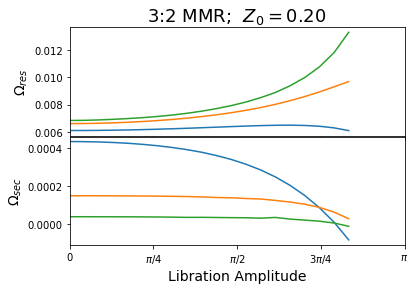

In [4]:
fig,ax = plt.subplots(2,sharex=True,figsize=(6,4))
plt.subplots_adjust(hspace=0.01)

amps = np.linspace(0,5*np.pi/6,20)
for Z0 in [0.05,0.1,0.2]:
    Jstar = res_model.Zsq_to_J * (Z0)**2
    Omega_res,Omega_sec = np.zeros((2,len(amps))) 
    for i,amp in enumerate(amps):
        Omega_res[i],Omega_sec[i]= calc_frequencies(amp,Jstar,res_model)
    ax[0].plot(amps,Omega_res)
    ax[1].plot(amps,Omega_sec)

# NOTE: Omega_sec needs to be corrected with
# addition of $\epsilon * b_s$ 
a_s,b_s,c_s = res_model.secular_coeffs()
eps_bs = b_s * res_model.eps
Omega_sec += eps_bs

ax[1].set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
ax[1].xaxis.set_ticklabels(["0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"]);
ax[0].set_title("{}:{} MMR;  $Z_0={:.2f}$".format(res_model.j,res_model.j-res_model.k,Z0),fontsize = 18)
ax[1].set_xlim(0,np.pi)
ax[1].set_xlabel("Libration Amplitude",fontsize=14)
ax[0].set_ylabel(r"$\Omega_{res}$",fontsize=14)
ax[1].set_ylabel(r"$\Omega_{sec}$",fontsize=14)

# Full range of secular frequencies 
The frequency $\Omega_\text{sec}$ is a function of the resonant libration amplitude. 
The frequency will range from $\Omega_\text{sec,ell}$ to $\Omega_\text{sec,unst}$
$$ 
\Omega_\text{sec,ell/unst} \approx -A(J^*-J_\text{ell/unst})/k^2 +\epsilon b_s
$$
at the elliptic fixed point to 

../IntegrableResonanceModel.py:410: RuntimeWarning: Search for elliptic fixed point did not converge!
  warn( RuntimeWarning("Search for elliptic fixed point did not converge!") )


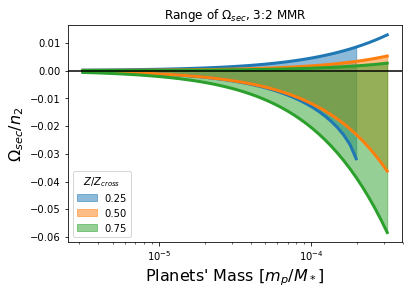

In [5]:
_,b_s,_ = res_model.secular_coeffs()
for zfrac in [0.25,0.5,.75]:
    
    # Lists to store secular frequencies at the 
    # elliptic and unstable fixed points, respectively
    OmegaEll, OmegaUnst =[], []
    # Planet masses to consider
    mpts = np.logspace(-5.5,-3.5)
    for m in mpts:
        res_model.m1 = m
        res_model.m2 = m
        _,_,Z0 = res_model.get_z1z2Z_from_zfrac(zfrac)
        Jstar = res_model.Zsq_to_J * (Z0)**2
        OmegaEll.append(calc_frequencies(0,Jstar,res_model)[1] + b_s * res_model.eps)
        OmegaUnst.append(calc_frequencies(np.pi,Jstar,res_model)[1] + b_s * res_model.eps)
    line, = plt.plot(mpts,OmegaEll,lw=3)
    plt.plot(mpts,OmegaUnst,color=line.get_color(),lw=3)
    plt.fill_between(mpts,OmegaEll,OmegaUnst,alpha = 0.5,label = "{:.2f}".format(zfrac),color=line.get_color())
    
plt.xscale('log')
plt.axhline(0.0,color='k')
plt.xlabel("Planets' Mass [$m_p/M_*$]", fontsize=16)
plt.ylabel(r"$\Omega_{sec} / n_2$ ", fontsize = 16)
plt.title(r"Range of $\Omega_{sec}$"+", {}:{} MMR".format(res_model.j,res_model.j-res_model.k))
plt.legend(title=r"$Z/Z_{cross}$")